In [63]:
%pwd

'/Users/erinhansen/Documents/DSE/capstone/DataExploration/Financial-Modeling'

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.spatial.distance import mahalanobis

import matplotlib.pyplot as plt
import seaborn as sns

import clustering

In [2]:
'''
Read, clean, and separate data by form type.
'''
df_original = pd.read_csv('../../../capstone-data/SampleData_v3.csv', 
                 dtype= {'FormationYr':'object'},
                 low_memory=False)

# get the columns used for financial clustering
with open('../columns_v2.csv') as fin_columns_csv:
    fin_columns = fin_columns_csv.read().split('\n')

# for each column, rename without /IRS990/ in the front
clean_cols = {}
for col in fin_columns:
    if col.startswith('/IRS990EZ/'):
        clean_cols[col] = col.replace('/IRS990EZ/','')
    elif col.startswith('/IRS990'):
        clean_cols[col] = col.replace('/IRS990/','')
    else:
        clean_cols[col] = col

df_original = df_original[fin_columns]      
df_original = df_original.rename(columns=clean_cols)
df_original['EIN'] = df_original['EIN'].apply(pd.to_numeric, errors='ignore')

text = pd.read_csv('/Users/erinhansen/Documents/DSE/capstone/web_application/data/text_clusters.csv')
df_original = text[['EIN']].merge(df_original, how = 'inner', on = 'EIN')
df_original = df_original.drop_duplicates()


df_990 = df_original[df_original['FormType'] == '990']
df_990 = df_990.drop(['FormType'], axis = 1)
df_990 = df_990.dropna(how = "all", axis = 1)
df_990 = df_990.fillna(0)
df_990.reset_index(inplace=True, drop = True)

# df_990EZ = df_original[df_original['FormType'] == '990EZ']
# df_990EZ = df_990EZ.drop(['FormType'], axis = 1)
# df_990EZ = df_990EZ.dropna(how = "all", axis = 1)
# df_990EZ = df_990EZ.fillna(0)
# df_990EZ.reset_index(inplace=True, drop = True)

### Form 990 Modeling

In [3]:
'''
Data prep & feature engineering
'''

# Functions for cleaning
def replace_infinity(result):
    result = result.fillna(0)
    result = result.replace(np.inf, 1.0)
    result = result.replace(-np.inf, 0.0)
    return result

def calculatePercentChange(series1, series2):
    result = (series1-series2)/series1
    return replace_infinity(result)

def scaleColumns(df, cols_to_scale, scaler):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df



# Transform required boolean columns to binary
df_990['ScheduleBRequiredInd'] = df_990['ScheduleBRequiredInd'].replace('false', 0).replace('true', 1).replace('0', 0).replace('1', 1).astype('int64')
df_990['TaxExemptBondsInd'] = df_990['TaxExemptBondsInd'].replace('false', 0).replace('true', 1).replace('0', 0).replace('1', 1).astype('int64')

# Related Org binary
df_990['RelatedOrg'] = df_990['RelatedOrganizationsAmt'].apply(lambda row: 1 if row != 0 else row)

# Transform formation year into age calcualtion
df_990['FormationYr'] = df_990['FormationYr'].astype('int64')
now = datetime.now()

# Age is current year minus formation year, else 0
df_990['FilerAge'] = df_990['FormationYr'].apply(lambda x: now.year-x if x != 0 else 0)

# TotalContributionsAmt divided by RevenueAmt
df_990['TotalContribRatio'] = df_990['TotalContributionsAmt']/df_990['RevenueAmt']
df_990['TotalContribRatio'] = replace_infinity(df_990['TotalContribRatio'])

# ProgramServicesAmt divided by TotalAmt
df_990['ProgramServicesRatio'] = df_990['TotalFunctionalExpensesGrp/ProgramServicesAmt']/df_990['TotalFunctionalExpensesGrp/TotalAmt']
df_990['ProgramServicesRatio'] = replace_infinity(df_990['ProgramServicesRatio'])

# ManagementAndGeneralAmt divided by TotalAmt
df_990['ManagementExpRatio'] = df_990['TotalFunctionalExpensesGrp/ManagementAndGeneralAmt']/df_990['TotalFunctionalExpensesGrp/TotalAmt']
df_990['ManagementExpRatio'] = replace_infinity(df_990['ManagementExpRatio'])

# FundraisingAmt divided by TotalAmt
df_990['FundraisingRatio'] = df_990['TotalFunctionalExpensesGrp/FundraisingAmt']/df_990['TotalFunctionalExpensesGrp/TotalAmt']
df_990['FundraisingRatio'] = replace_infinity(df_990['FundraisingRatio'])

# % Change of Assets over the year
# df_990['PercentTotalAsstChng'] = calculatePercentChange(df_990['TotalAssetsGrp/BOYAmt'], df_990['TotalAssetsGrp/EOYAmt'])
df_990['PercentFundBalChng'] = calculatePercentChange(df_990['TotLiabNetAssetsFundBalanceGrp/BOYAmt']-df_990['TotalLiabilitiesGrp/BOYAmt'], df_990['TotLiabNetAssetsFundBalanceGrp/EOYAmt']-df_990['TotalLiabilitiesGrp/EOYAmt'])
df_990['PercentTotalLiabChng'] = calculatePercentChange(df_990['TotalLiabilitiesGrp/BOYAmt'], df_990['TotalLiabilitiesGrp/EOYAmt'])

# % Change Previous Year to Current Year
df_990['PercentSalaryChng'] = calculatePercentChange(df_990['PYSalariesCompEmpBnftPaidAmt'], df_990['CYSalariesCompEmpBnftPaidAmt'])
df_990['PercentTotalExpenseChng'] = calculatePercentChange(df_990['PYTotalExpensesAmt'], df_990['CYTotalExpensesAmt'])
df_990['PercentProfFndrsngExpnsChng'] = calculatePercentChange(df_990['PYTotalProfFndrsngExpnsAmt'], df_990['CYTotalProfFndrsngExpnsAmt'])
df_990['PercentRevenueChng'] = calculatePercentChange(df_990['PYTotalRevenueAmt'], df_990['CYTotalRevenueAmt'])

# Drop Columnsn
df_990 = df_990.drop(columns=['FormationYr',
                      'TotalContributionsAmt',
                      'TotalFunctionalExpensesGrp/ProgramServicesAmt',
                      'TotalFunctionalExpensesGrp/ManagementAndGeneralAmt',
                      'TotalFunctionalExpensesGrp/FundraisingAmt',
#                       'TotalAssetsGrp/BOYAmt',
                      'TotLiabNetAssetsFundBalanceGrp/BOYAmt',
                      'TotLiabNetAssetsFundBalanceGrp/EOYAmt',
                      'TotalLiabilitiesGrp/BOYAmt',
                      'RelatedOrganizationsAmt',
                      'CYSalariesCompEmpBnftPaidAmt',
                      'CYTotalExpensesAmt',
                      'CYTotalProfFndrsngExpnsAmt',
                      'CYTotalRevenueAmt',
                      'PYSalariesCompEmpBnftPaidAmt',
                      'PYTotalExpensesAmt',
                      'PYTotalProfFndrsngExpnsAmt',
                      'PYTotalRevenueAmt'      
                     ])

# Scale columns where it makes sense to
cols = df_990.columns
set_cols = set(cols)
cols_not_scale = ['EIN', 
                  'FilerAge',
                  'TotalContribRatio',
                  'ProgramServicesRatio',
                  'FundraisingRatio',
                  'ManagementExpRatio',
                  'PercentFundBalChng',
#                   'PercentTotalAsstChng',
                  'PercentTotalLiabChng',
                  'PercentSalaryChng',
                  'PercentTotalExpenseChng',
                  'PercentProfFndrsngExpnsChng',
                  'PercentRevenueChng',
                  'RelatedOrg',
                  'ScheduleBRequiredInd',
                  'TaxExemptBondsInd'
                 ]

for col in cols_not_scale:
    set_cols.remove(col)
    
scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()

df_990 = scaleColumns(df_990, list(set_cols), min_max_scaler)

[0.67117195 0.99374422 0.99688235 0.99882763 0.99981489 0.99994553
 0.99999965 0.99999992 0.99999996 0.99999998 0.99999999 0.99999999
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]


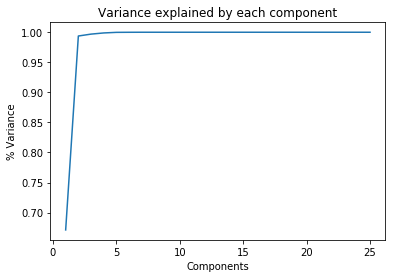

In [5]:
'''
Dimensionality reduction with PCA
'''

# Helper functions
def PCA_components(df):
    pca = PCA()
    pca.fit(df.loc[:, df.columns != 'EIN'])
    df_pca = pca.transform(df.loc[:, df.columns != 'EIN'])
    var = pca.explained_variance_ratio_
    var_cumsum = np.cumsum(var)
    comp = range(1, len(var)+1)

    %matplotlib inline
    plt.plot(comp,var_cumsum)
    plt.xlabel('Components')
    plt.ylabel('% Variance')
    plt.title('Variance explained by each component')
    print(var_cumsum)

def fit_pca(df, n):
    eins = list(df['EIN'])
    pca = PCA(n_components = n)
    pca.fit(df.loc[:, df.columns != 'EIN'])
    df_pca = pca.transform(df.loc[:, df.columns != 'EIN'])
    df_pca = pd.DataFrame(df_pca)
    df_pca['EIN'] = eins
    return df_pca

PCA_components(df_990)
df_990_reduced = fit_pca(df_990, 5)

In [6]:
'''
Hierarchical clustering using clustering.py script
'''
X = df_990_reduced.loc[:, df_990_reduced.columns != 'EIN'].values

'''
Z is linkage matrix
gap_metrics is dictionary of ks, logWs, logBWs, and stderr values
bc is best number of clusters
clusters are labels
'''
Z, gap_metrics, bc, clusters_990 = clustering.create_clusters(X, C = 500)

df_990['labels'] = clusters_990
# df_990.groupby(['labels']).count()['EIN']

Scanning: 10
Scanning: 20
Scanning: 30
Scanning: 40
Scanning: 50
Scanning: 60
Scanning: 70
Scanning: 80
Scanning: 90
Scanning: 100
Scanning: 110
Scanning: 120
Scanning: 130
Scanning: 140
Scanning: 150
Scanning: 160
Scanning: 170
Scanning: 180
Scanning: 190
Scanning: 200
Scanning: 210
Scanning: 220
Scanning: 230
Scanning: 240
Scanning: 250
Scanning: 260
Scanning: 270
Scanning: 280
Scanning: 290
Scanning: 300
Scanning: 310
Scanning: 320
Scanning: 330
Scanning: 340
Scanning: 350
Scanning: 360
Scanning: 370
Scanning: 380
Scanning: 390
Scanning: 400
Scanning: 410
Scanning: 420
Scanning: 430
Scanning: 440
Scanning: 450
Scanning: 460
Scanning: 470
Scanning: 480
Scanning: 490
Scanning: 500

Cluster sizes: [146 148 156 159 172 176 180 183 184 186 191 196 200 203 204 208 210 212
 215 218 222 224 226 228 230 232 235 237 239 240 243 244 246 247 248 249
 250 252 253 256 258 259 260 262 263 264 265 266 267 268 270 271 273 274
 275 276 277 280 281 282 283 285 286 287 288 290 291 292 294 295 296 297
 

### Form 990EZ Modeling

In [ ]:
'''
Data prep & feature engineering
'''

# # Calculate Total Liabilities column
# df_990EZ['TotalLiabilitiesGrp/EOYAmt'] = df_990EZ['Form990TotalAssetsGrp/EOYAmt'] - df_990EZ['NetAssetsOrFundBalancesGrp/EOYAmt']
# df_990EZ = df_990EZ.drop(columns=['Form990TotalAssetsGrp/EOYAmt'])

# # Scale columns where it makes sense to
# cols = df_990EZ.columns
# set_cols = set(cols)
# cols_not_scale = ['EIN']

# for col in cols_not_scale:
#     set_cols.remove(col)
    
# scaler = preprocessing.StandardScaler()
# min_max_scaler = preprocessing.MinMaxScaler()

# df_990EZ = scaleColumns(df_990EZ, list(set_cols), min_max_scaler)

In [ ]:
'''
Hierarchical clustering using clustering.py script
'''
# X = df_990EZ.loc[:, df_990EZ.columns != 'EIN'].values

# '''
# Z is linkage matrix
# gap_metrics is dictionary of ks, logWs, logBWs, and stderr values
# bc is best number of clusters
# clusters are labels
# '''
# Z, gap_metrics, bc, clusters_990EZ = clustering.create_clusters(X, C = 500)

# df_990EZ['labels'] = clusters_990EZ
# # df_990EZ.groupby(['labels']).count()['EIN']

### Merge cluster results

In [ ]:
'''
Combine original data sets and re-scale
'''

# df_all = df_original[['EIN', 'GrossReceiptsAmt']]
# df_all = df_all.fillna(0)
# df_all = scaleColumns(df_all, ['GrossReceiptsAmt'], min_max_scaler)
# df_all = df_all.merge(df_990[['EIN', 'labels']], how = 'left', on = 'EIN')
# df_all = df_all.merge(df_990EZ[['EIN', 'labels']], how = 'left', on = 'EIN')
# df_all = df_all.rename(index=str, columns = {'labels_x': 'labels_990', 'labels_y': 'labels_EZ'})


# '''
# Find the means of GrossReceiptAmt for each cluster
# '''
# means990 = df_all[~df_all['labels_990'].isna()]
# means990 = pd.DataFrame(means990.groupby(['labels_990']).mean()['GrossReceiptsAmt'])
# means990.reset_index(inplace = True)
# x990 = means990.values

# meansEZ = df_all[~df_all['labels_EZ'].isna()]
# meansEZ = pd.DataFrame(meansEZ.groupby(['labels_EZ']).mean()['GrossReceiptsAmt'])
# meansEZ.reset_index(inplace = True)
# xEZ = meansEZ.values


# '''
# Calculate similarity scores based on cluster means 
# 1 row per EZ cluster, 1 col per 990 cluster
# '''
# similarity_scores = euclidean_distances(xEZ[:,1:], x990[:,1:])


# '''
# Creates column for the min sim score (i.e. closest match) and position of closest cluster
# '''
# min_distance = []
# position = []
# for row in similarity_scores:
#     min_distance.append(min(row))
#     position.append(min(enumerate(row),key=lambda x: x[1])[0])

# meansEZ['min_distance'] = min_distance
# meansEZ['position'] = position


# '''
# Bring in means990 data for closest cluster
# '''
# combined_clusters = meansEZ.merge(means990, how = 'left', left_on = 'position', right_index = True)
# combined_clusters = combined_clusters.rename(index=str, columns = {'GrossReceiptsAmt_y': 'GrossReceiptsAmt_990', 'GrossReceiptsAmt_x': 'GrossReceiptsAmt_EZ'})


# '''
# If min distance < threshold, merge clusters, otherwise keep create new cluster
# '''
# threshold = .000001
# new_cluster_id = max(df_990['labels'])
# final_labels = []
# for i in combined_clusters.index:
#     if combined_clusters.loc[i, 'min_distance'] < threshold:
#         final_labels.append(combined_clusters.loc[i, 'labels_990'])
#     else:
#         new_cluster_id += 1
#         final_labels.append(new_cluster_id)
# combined_clusters['final_labels'] = [int(x) for x in final_labels]
# combined_clusters['labels_EZ'] = combined_clusters['labels_EZ'].astype('int64')


# '''
# Add final_label to df_990EZ dataframe
# '''
# df_990EZ = df_990EZ.merge(combined_clusters[['labels_EZ', 'final_labels']], how = 'left', left_on = 'labels', right_on = 'labels_EZ')
# df_990EZ = df_990EZ.drop(['labels', 'labels_EZ'], axis = 1)
# df_990EZ = df_990EZ.rename(index = str, columns = {'final_labels': 'labels'})

# '''
# Final dataframe with labels
# '''
# df_original = df_original.merge(df_990[['EIN', 'labels']], how = 'left', on = 'EIN')
# df_original = df_original.merge(df_990EZ[['EIN', 'labels']], how = 'left', on = 'EIN')
# df_original['labels'] = df_original['labels_x'].combine_first(df_original['labels_y'])
# df_original = df_original.drop(['labels_x', 'labels_y'], axis = 1)
# df_original['labels'] = df_original['labels'].astype('int64')

In [ ]:
# df_original.to_csv('./labels_M7.csv', index = False)

In [2]:
# def scaleColumns(df, cols_to_scale, scaler):
#     for col in cols_to_scale:
#         df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
#     return df
# min_max_scaler = preprocessing.MinMaxScaler()

In [3]:
'''
Data for variance visualization (Tableau)
'''

# # df_original = pd.read_csv('./labels_M7.csv', dtype = {'FormType': 'object'})
# df_final_990 = df_original[df_original['FormType'] == '990']
# df_final_990 = df_final_990[['EIN', 'GrossReceiptsAmt', 'RevenueAmt', 'TotalNetAssetsFundBalanceGrp/EOYAmt', 'TotalLiabilitiesGrp/EOYAmt', 'labels']]
# df_final_990.columns = ['EIN', 'Gross Receipts', 'Revenue', 'Fund Balance', 'Liabilities', 'labels']

# df_final_990EZ = df_original[df_original['FormType'] == '990EZ']
# df_final_990EZ['TotalLiabilitiesGrp/EOYAmt'] = df_final_990EZ['Form990TotalAssetsGrp/EOYAmt'] - df_final_990EZ['NetAssetsOrFundBalancesGrp/EOYAmt']
# df_final_990EZ = df_final_990EZ[['EIN', 'GrossReceiptsAmt', 'TotalRevenueAmt', 'NetAssetsOrFundBalancesGrp/EOYAmt', 'TotalLiabilitiesGrp/EOYAmt', 'labels']]
# df_final_990EZ.columns = ['EIN', 'Gross Receipts', 'Revenue', 'Fund Balance', 'Liabilities', 'labels']

# df_final = df_final_990.append(df_final_990EZ)
# df_final = df_final.fillna(0)

# cols = list(df_final.columns)[1:-1]
# df_final = scaleColumns(df_final, cols, min_max_scaler)
# df_final.to_csv('./var_viz_M7.csv', index = False)

/Users/erinhansen/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/erinhansen/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [7]:
df_final = df_990_reduced
df_final['labels'] = clusters_990

EINS = df_final['EIN']
# df_final = df_final.drop('EIN', axis = 1)

In [8]:
'''
Calculate distance from cluster center for each org.
'''

cluster_means = pd.DataFrame(df_final.groupby(['labels']).mean()).reset_index()
cluster_means.drop(['EIN'], inplace=True, axis = 1)
cluster_means = cluster_means.values

clusters = set(df_final['labels'])
names = ["fin_dist_" + str(cluster) for cluster in clusters]

'''
Try Euclidean, cosine, and Mahalanobis
'''

for i, row in enumerate(df_final.values):
    for means in cluster_means:
        for cluster in clusters:
            if means[0] == cluster: # check for same cluster label
                x = row[0:-2].reshape([1,5])
                y = means[1:].reshape([1,5])
                df_final.loc[i, names[cluster-1]] = (float(cosine_similarity(x, y)))

In [6]:
# df_final.to_csv('./df_final_M7.csv', index = False)
# df_final.to_csv('./df_final_M8_cosine2.csv', index = False)

In [10]:
df_final.to_csv('/Users/erinhansen/Documents/DSE/capstone/web_application/data/fin_clusters.csv', index = False)